# Time Series Forecasting with "Shallow Learning"

Before we get to ML techniques commonly called "deep learning" (e.g. **recurrent neural networks**), let's see what we can do with simpler ML methods. These techniques are the topic of our course [📓 Machine Learning with Python](../index/mlp2-machine-learning-python.ipynb), and the library `scikit-learn` provides most of the code needed. We assume that you are familiar with the concepts.

## Preamble

In [1]:
import pandas
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [2]:
import forecast_lab

In [3]:
seaborn.set_style("ticks")
matplotlib.pyplot.rcParams["axes.grid"] = True
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)

## Example: Forecasting Taxi Trips

In [4]:
taxi_trips = forecast_lab.datasets.read_chicago_taxi_trips_daily()

In [5]:
taxi_trips.head()

,Trips
Date,
2013-01-01,96
2013-01-02,53
2013-01-03,61
2013-01-04,79
2013-01-05,76


## Transform to Supervised Learning Problem

It is possible to pack a time series forecasting problem into the traditional form for supervised machine learning: A set of labelled observations, more specifically a matrix $X$ of feature values and a vector $y$ of labels .

In [6]:
from forecast_lab.core import transform_to_labelled_points

In [7]:
transform_to_labelled_points??

Signature: transform_to_labelled_points(ts, window_size)
Source:   
def transform_to_labelled_points(ts, window_size):
    """
    Given a series of values and a window size, it turns
    them into labelled points X,y by sliding the window over the series.
    """
    feature_columns = [f"x_{i}" for i in range(window_size)]
    columns = feature_columns + ["y"]
    rows = []
    for window in sliding_window(ts, window_size + 1):
        label = window[-1]
        features = window[:-1]
        row = dict(zip(columns, features + [label]))
        rows.append(row)
    data = pandas.DataFrame(rows, columns=columns)
    return data[feature_columns], data["y"]
File:      ~/Documents/Freelancing/Projects/point8/DataScience101/forecast-lab/forecast_lab/core.py
Type:      function


In [8]:
X_train, y_train = transform_to_labelled_points(taxi_trips["Trips"][:1000], 10)

In [9]:
X_test, y_test = transform_to_labelled_points(taxi_trips["Trips"][1000:2000], 10)

We now have the data in the familiar format for supervised learning: A feature matrix $X$ and a label vector $y$ - only that the features are the preceding $w$ values of the time series.

In [10]:
X_train.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,96,53,61,79,76,62,60,63,68,75
1,53,61,79,76,62,60,63,68,75,80
2,61,79,76,62,60,63,68,75,80,97
3,79,76,62,60,63,68,75,80,97,70
4,76,62,60,63,68,75,80,97,70,74


In [11]:
y_train.head()

0    80
1    97
2    70
3    74
4    72
Name: y, dtype: int64

We can now fit ML models, e.g. from **scikit-learn**:

In [12]:
import sklearn

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
model = GradientBoostingRegressor().fit(X_train, y_train)

Let's use the model for predictions on the test feature matix and compare with the ground truth:

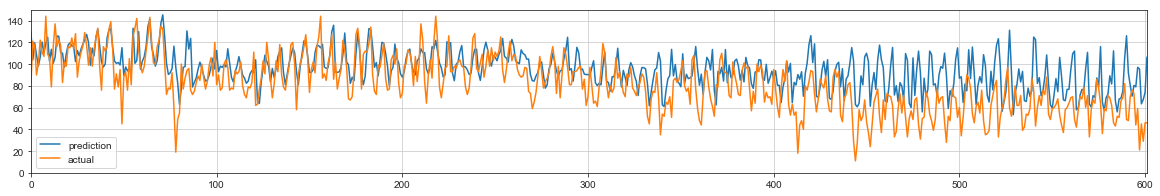

In [15]:
pandas.DataFrame(
    {
        "prediction": model.predict(X_test),
        "actual": y_test       
    }
).plot(ylim=(0,150))

Not bad - a point in the series can be predicted from the the preceding ones with some accuracy, and we see similar seasonal patterns. With time, the forecast deteriorates somewhat - which may be due to [**concept drift**](https://en.m.wikipedia.org/wiki/Concept_drift).

However, this is not yet a proper time series forecast as we have defined it. The model only forecasts one step ahead and is provided with the actual values from the time segment we want to predict. In the following, we discuss how to generate a forecast for arbitrary time steps with recursive forecasting.

## Using the Model for Recursive Forecasting

In order to do recursive forecasting, the model needs to be supplied with a rolling window of its own predictions. We have prepared some code for you in the `ScikitLearnWrapper` class: 

In [16]:
forecast_lab.ScikitLearnWrapper.forecast??

Signature:
forecast_lab.ScikitLearnWrapper.forecast(
    self,
    steps: int,
    ext_vars: pandas.core.frame.DataFrame = None,
)
Source:   
    def forecast(
        self,
        steps: int,
        ext_vars: pandas.DataFrame = None
    ):
        """
        Forecast the time series for the given
        number of steps after the end of the
        training series.
        """
        w = self.sliding_window_size
        ts_tail = list(self.ts_train[-(w):].values)
        ts_forecast = []
        for i in range(steps):
            if ext_vars is not None:
                n_features = w + ext_vars.shape[1] # number of feature columns
                X = numpy.array(ts_tail + list(ext_vars.iloc[i].values)).reshape((1, n_features))
            else:
                X = numpy.array(ts_tail).reshape((1, w))
            y = self.model.predict(
                X
            )
            ts_forecast += [y[0]]
            ts_tail = ts_tail[1:] + [y[0]]

        return numpy.array(ts_foreca

Now we can evaluate a true forecast for a given horizon. Have a look at the diagnostic plots:
- training, test and forecast segments
- residuals: test versus forecast
- pull plot: distribution of errors

In [17]:
metrics = {
            "MAPE": forecast_lab.metrics.mean_absolute_percentage_error,
            "RSME": forecast_lab.metrics.root_mean_squared_error
        }

======== iteration 0 ==========


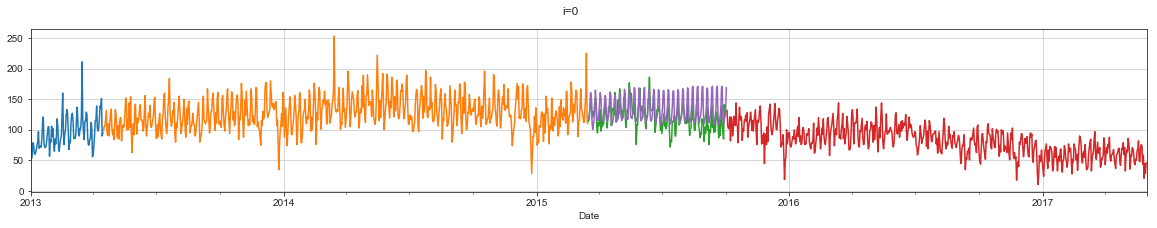

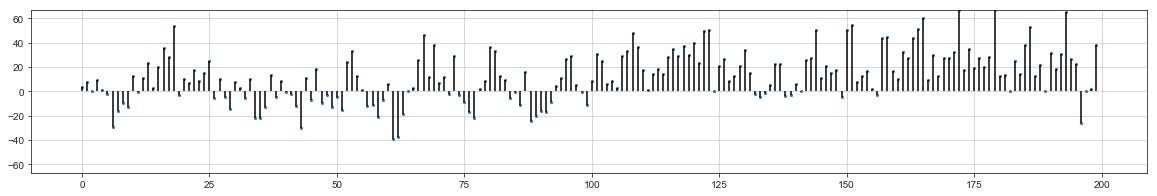

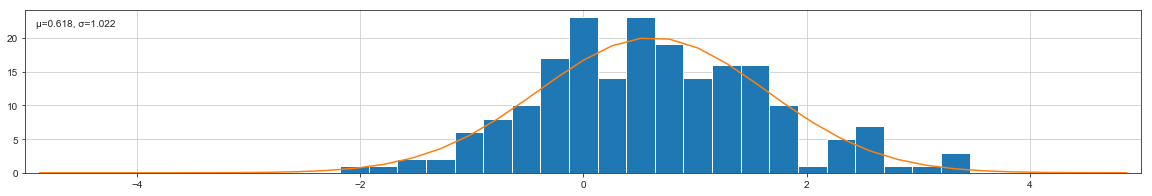

======== iteration 1 ==========


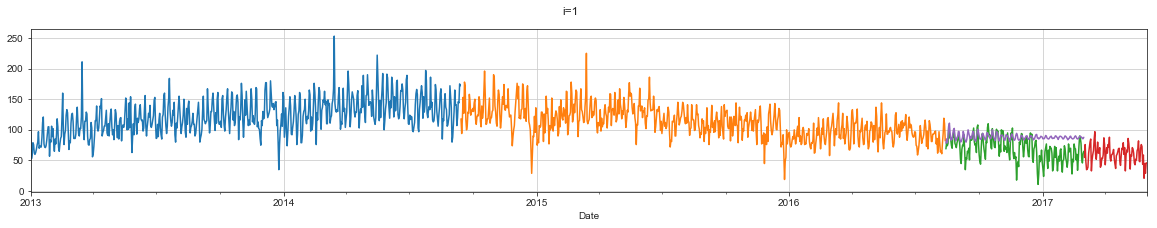

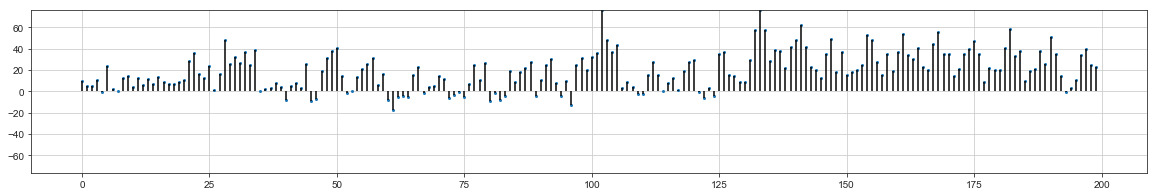

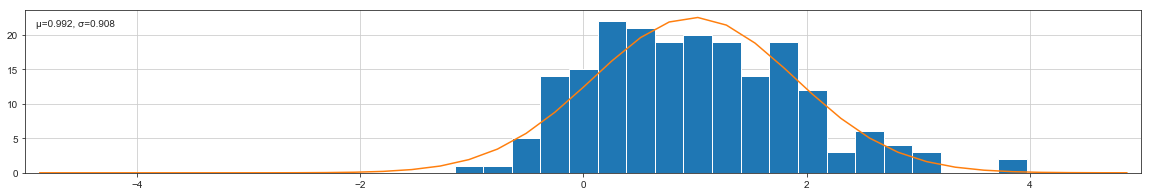

======== iteration 2 ==========


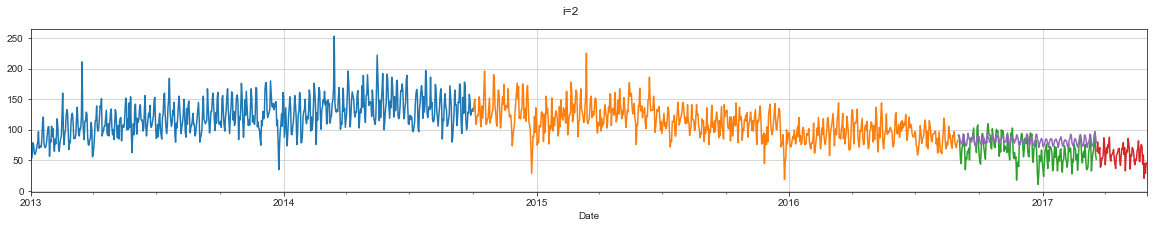

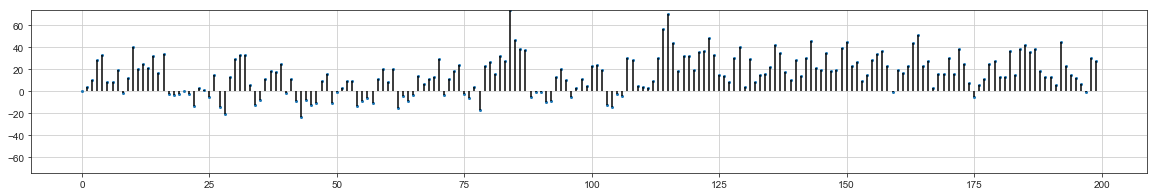

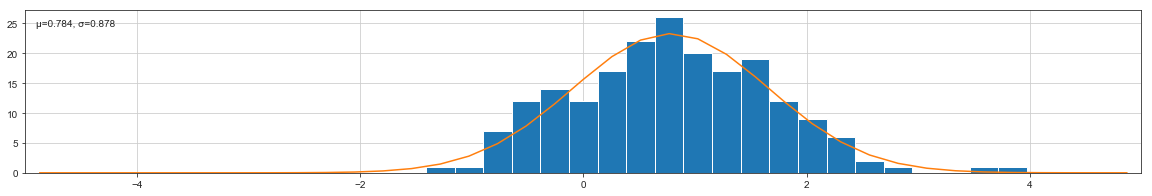

MAPE    33.946856
RSME    24.458406
dtype: float64

In [18]:
forecast_lab.ForecastEvaluation(
        ts=taxi_trips["Trips"],
        forecasting=forecast_lab.ScikitLearnWrapper(
            GradientBoostingRegressor,
            sliding_window_size=100,
        ),
        test_window_size=200,
        train_window_size=700,
        metrics=metrics
).evaluate(
    k=3, 
    plot_segments=True,
    plot_residuals=True,
    plot_pulls=True
).get_metrics().mean()

## Incorporating External Variables

A nice property of this approach to forecasting is that it is straightforward to add external variables or even multiple other time series: Just add them as additional feature columns to the feature columns that come from the time series itself.

In [19]:
forecast_lab.ScikitLearnWrapper.fit??

Signature:
forecast_lab.ScikitLearnWrapper.fit(
    self,
    ts: pandas.core.series.Series,
    ext_vars: pandas.core.frame.DataFrame = None,
)
Source:   
    def fit(
        self,
        ts: pandas.Series,
        ext_vars: pandas.DataFrame = None,
    ):
        """
        Fit the model to a time series
        """
        X, y =  transform_to_labelled_points(
            ts,
            window_size=self.sliding_window_size
        )
        if ext_vars is not None:
            ext_X = ext_vars.iloc[self.sliding_window_size:].reset_index(drop=True) # align with labelled points
            X = pandas.concat([X, ext_X], axis=1, ignore_index=True) # concatenate columns
        self.model = self.estimator_class(
            **self.estimator_params
        ).fit(
            X,
            y,
            **self.fit_params
        )
        self.ts_train = ts # save for recursive forecast
        return self
File:      ~/Documents/Freelancing/Projects/point8/DataScience101/forecast-lab

### Example

Do the seasons influence the demand for taxi rides in any way? Hard to say, but we are going to try it out: As external variable, we take the average monthly temperature into account. Let's look at one year of data:

In [20]:
usa_temp = forecast_lab.datasets.read_usa_temperature()

In [21]:
usa_temp["2013"].head()

,Value,Anomaly
Date,,
2013-01-01,0.138889,-16.594444
2013-02-01,1.538889,-17.250000
2013-03-01,4.950000,-18.105556
2013-04-01,9.822222,-18.538889
2013-05-01,16.027778,-17.416667


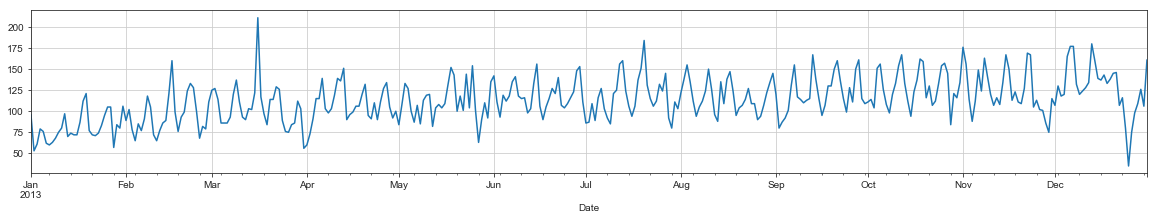

In [22]:
taxi_trips["2013"]["Trips"].plot()

The external variables must be passed in the form of a `pandas.DataFrame` with an index matching the time series.

Unfortunately we have only monthly data for the temperature, but we can resample it to a daily frequency to make it compatible:

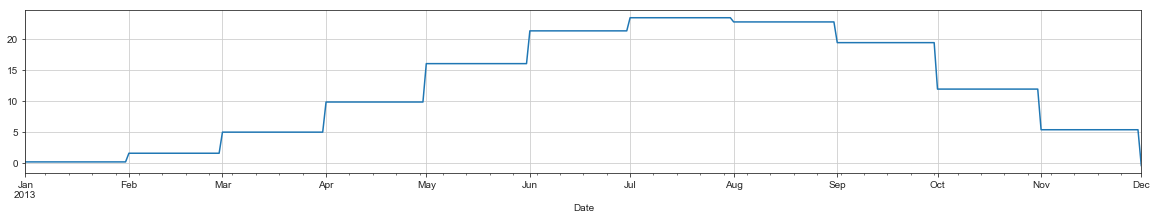

In [23]:
usa_temp["2013"]["Value"].resample("d").pad().plot()

Let's see if the fitting step works:

In [24]:
temperature = pandas.DataFrame(
        usa_temp["2013-01":"2014-01"]["Value"].resample("d").pad(),
)[:-1]

In [25]:
forecast_lab.ScikitLearnWrapper(
    estimator_class=GradientBoostingRegressor,
    sliding_window_size=60,
).fit(
    ts=taxi_trips["2013"]["Trips"],
    ext_vars=temperature
)

Now this can be used in the `ForecastEvaluation`. We need to make sure to pass external data matching both the index for the training and test time series.

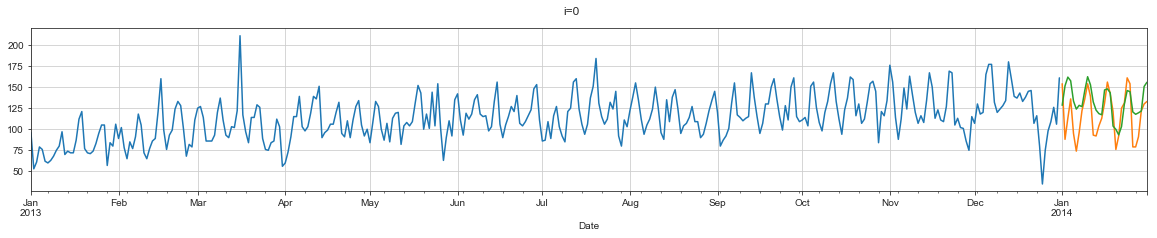

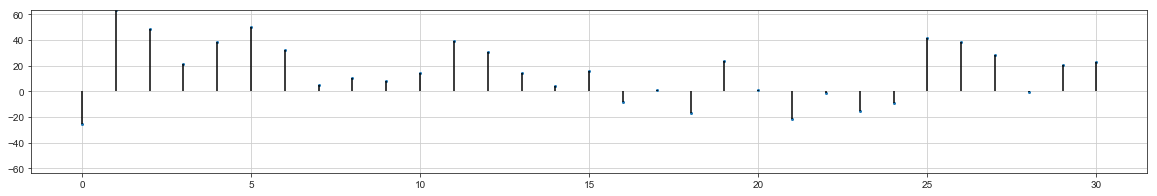

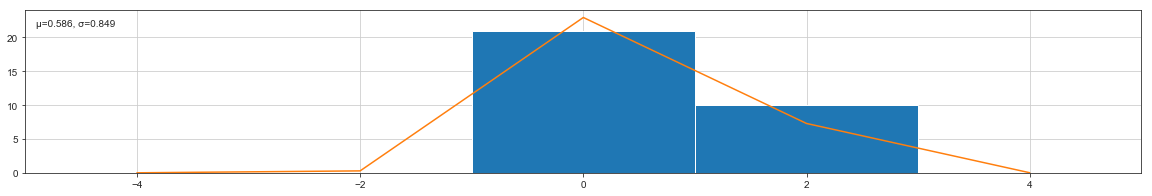

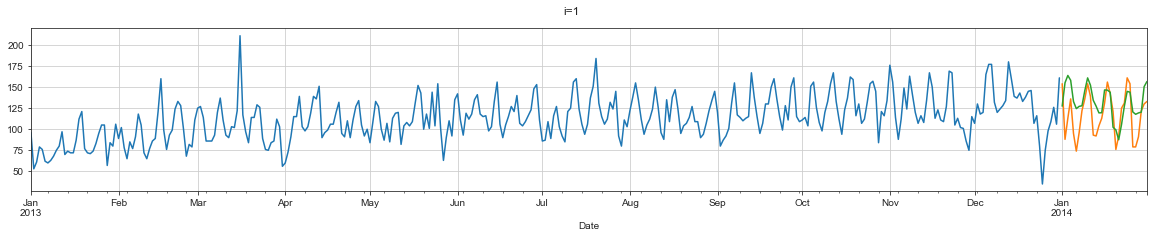

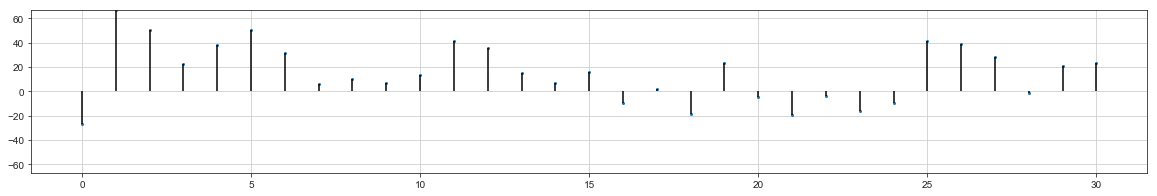

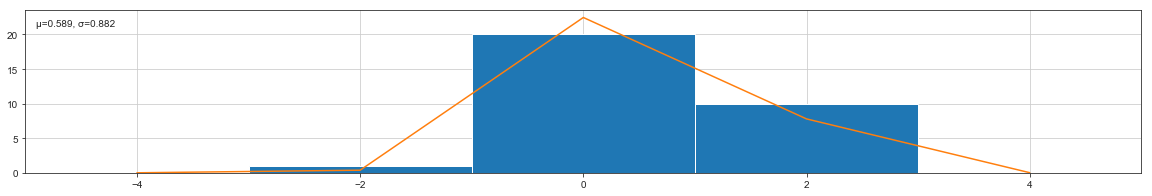

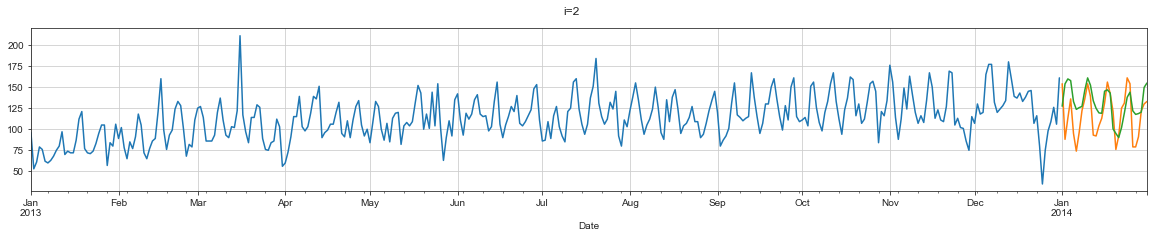

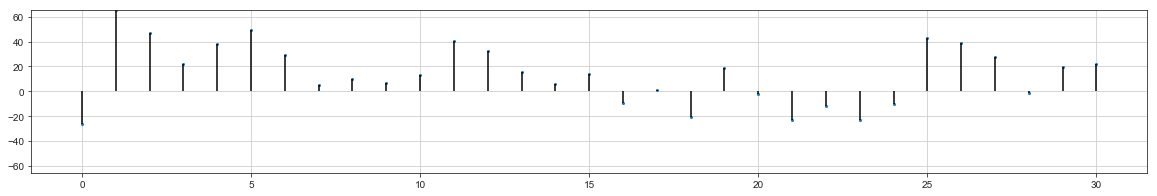

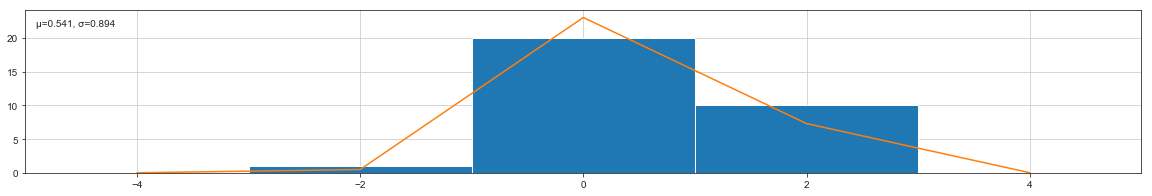

MAPE    22.165147
RSME    27.365378
dtype: float64

In [27]:
forecast_lab.ForecastEvaluation(
    ts=taxi_trips["2013"]["Trips"],
    ts_test=taxi_trips["2014-01"]["Trips"],
    ext_vars=pandas.DataFrame(
        usa_temp["2013-01":"2014-02"]["Value"].resample("d").pad(),
    ),
    forecasting=forecast_lab.ScikitLearnWrapper(
        GradientBoostingRegressor,
        sliding_window_size=120,
    ),
    metrics=metrics
).evaluate(
    k=3, 
    plot_segments=True,
    plot_residuals=True,
    plot_pulls=True
).get_metrics().mean()

## Summary

**Pros**

+ apply any supervised learning regressor to forecasting
+ reuse well-known ML methods and tools
+ easily add external features or other time series as additional columns in the feature matrix

**Cons**

- order of data points matters only within the sliding window - a possible limit to learning long patterns
- recursive forecast may deteriorate quickly the longer the forecast horizon as errors accumulate

## References

- [Time Series for scikit-learn People](https://www.ethanrosenthal.com/2018/01/28/time-series-for-scikit-learn-people-part1/)

---
_This notebook is licensed under a [Creative Commons Attribution 4.0 International License (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Copyright © 2019 [Point 8 GmbH](https://point-8.de)_

